<a href="https://colab.research.google.com/github/Raj2025-hub/ATTENTION-U-NET-BASED-AUTOMATED-SEGMENTATION-OF-FLOODED-AREAS/blob/main/flood_segmentation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flooded area segmentation using attention unet

Dataset used in this tutorial can be downloaded [here](https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation).

If you liked this tutorial, please suscribe to my youtube channel: [GeoDev](https://youtube.com/@geodev)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports and dataset

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install focal_loss -q

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import glob

In [ ]:
# Correct the path to your dataset if needed.
images = sorted(glob.glob('/content/drive/MyDrive/archive/Image/*.jpg'))
masks = sorted(glob.glob('/content/drive/MyDrive/archive/Mask/*.png'))
print(f"Found {len(images)} images and {len(masks)} masks.")

Found 290 images and 290 masks.


## Custom data generator

In [ ]:
import numpy as np
import cv2
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, img_size=(512, 512), shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.images = images #os.listdir(image_folder)
        self.masks = masks #os.listdir(mask_folder)

        # on each epoch end, shuffle the dataset
        self.on_epoch_end()

        # datagen function to augment the input image and mask pair
        self.datagen = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode = 'constant',
            cval=0.0,
        )

    # randomly crop the images to 512x512 size
    def random_crop(self, image, mask, crop_size=512):

        # image width and height calculation
        img_height, img_width = image.shape[0], image.shape[1]
        mask_height, mask_width = mask.shape[0], mask.shape[1]

        # random x and y coordinate for cropping the image
        x = np.random.randint(0, img_width - crop_size)
        y = np.random.randint(0, img_height - crop_size)

        # random crop
        image_crop = image[y:y + crop_size, x:x + crop_size, :]
        mask_crop = mask[y:y + crop_size, x:x + crop_size]

        return image_crop, mask_crop

    # data augmentation using keras ImageDataGenerator function
    def data_augmentation(self, image, mask):
        trans_param = self.datagen.get_random_transform(image.shape)
        image = self.datagen.apply_transform(image, trans_param)
        mask = self.datagen.apply_transform(mask, trans_param)
        return image, mask

    # length of the processing batch
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    # data normalization
    def data_normalization(self, image, mask):

        # reshape mask from 512x512 to 512x512x1
        mask = mask.reshape((*self.img_size, 1))

        # Binary mask
        mask = np.where(mask<127, 0, 1)

        # data normalization (If you want to normalize another way, change the below line)
        image = image / 255.0

        # return image and mask
        return image, mask

    # data preprocessing, resize, crop image etc
    def data_preprocessing(self, image, mask):
        image, mask = cv2.resize(image, (576, 576)), cv2.resize(mask, (576, 576))
        image, mask = self.random_crop(image, mask)
        return image, mask

    # on each epoch, shuffle the dataset (image and mask index)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # get item is the core function
    # this function will run in each batch/epoch to load the dataset into RAM and pass to DL model
    def __getitem__(self, index):

        # start and end index
        # the last index can be shorter than the number of batches
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.images))
        indexes = self.indexes[start_idx:end_idx]

        # initialize the images and mask batches
        batch_images = []
        batch_masks = []

        # iterate over each indexes in batch
        for i in indexes:
            img_path = self.images[i]
            mask_path = self.masks[i]

            # read image using open cv
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Skip if image or mask is not loaded properly
            if img is None or mask is None:
                continue

            # image preprocessing; resize, random crop
            img, mask = self.data_preprocessing(img, mask)

            # data normalization
            img, mask = self.data_normalization(img, mask)

            # data augmentation
            img, mask = self.data_augmentation(img, mask)

            # to fix the issue during training process
            mask = mask.astype(np.float32)

            # append each image, mask pair to the batches
            batch_images.append(img)
            batch_masks.append(mask)

        # return batch image and batch mamks as a numpy array (n, tile_x, tile_y, channels)
        return np.array(batch_images), np.array(batch_masks)


## Testing and visualization of image/mask pair

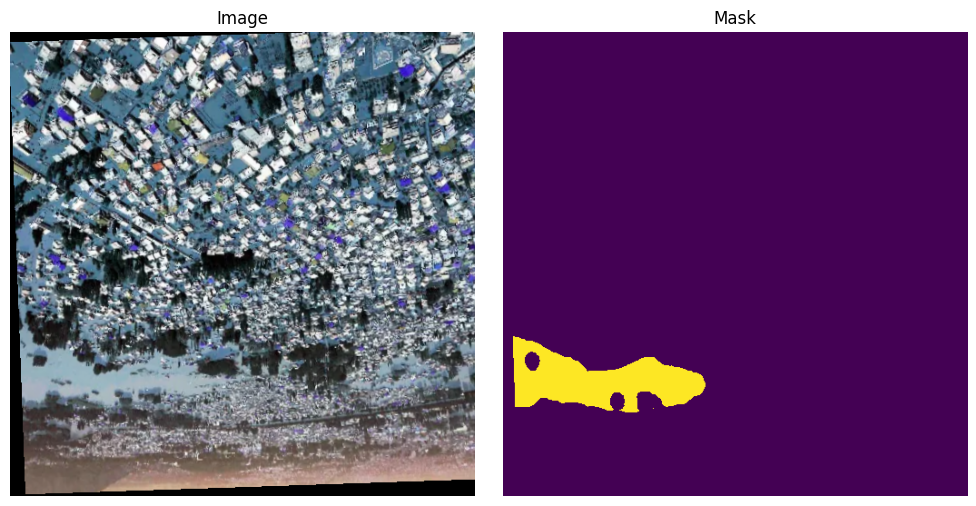

In [ ]:
import matplotlib.pyplot as plt

data = CustomDataGenerator(images, masks)
batch_images, batch_masks = data.__getitem__(0)

# Sample an index within the actual batch size
img_index = np.random.randint(0, len(batch_images))

# Visualize the first image and its mask from the batch
image = batch_images[img_index]
mask = batch_masks[img_index]

# Plotting the image and its mask
plt.figure(figsize=(10, 5))

# Display Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

# Display Mask
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

## Train and test dataset split

In [ ]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_mask, test_mask = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
len(train_img), len(test_img)

(232, 58)

In [ ]:
train_dataset = CustomDataGenerator(train_img, train_mask)
test_dataset = CustomDataGenerator(test_img, test_mask)

In [ ]:
len(train_dataset), len(test_dataset)

(29, 8)

## Custom metrics

1. Precision
2. Recall
3. F1-Score
4. Dice loss

## Custom loss function

Instead of default loss function (`binary_crossentropy`), you can use the `dice_loss` function implemented below as well.

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import backend as K

# # recall
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# # precision
# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# #f1 score
# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

# def dsc(y_true, y_pred):
#     smooth = 1.
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return score

# def dice_loss(y_true, y_pred):
#     loss = 1 - dsc(y_true, y_pred)
#     return loss

In [ ]:

# # weighted binary crosstropy function
# def weighted_binary_crossentropy(y_true, y_pred, weights=[0.5, 0.5]):
#     # Calculate weighted binary cross-entropy loss
#     class_weighted_loss = BinaryCrossentropy(from_logits=True)
#     loss = class_weighted_loss(y_true, y_pred)

#     # Calculate class weights for each pixel in the mask
#     weights = (1.0 - y_true) * weights[0] + y_true * weights[1]

#     # Apply the class weights to the loss for each pixel
#     weighted_loss = loss * weights

#     # Compute the mean loss over all pixels
#     return K.mean(weighted_loss)

## Attention unet

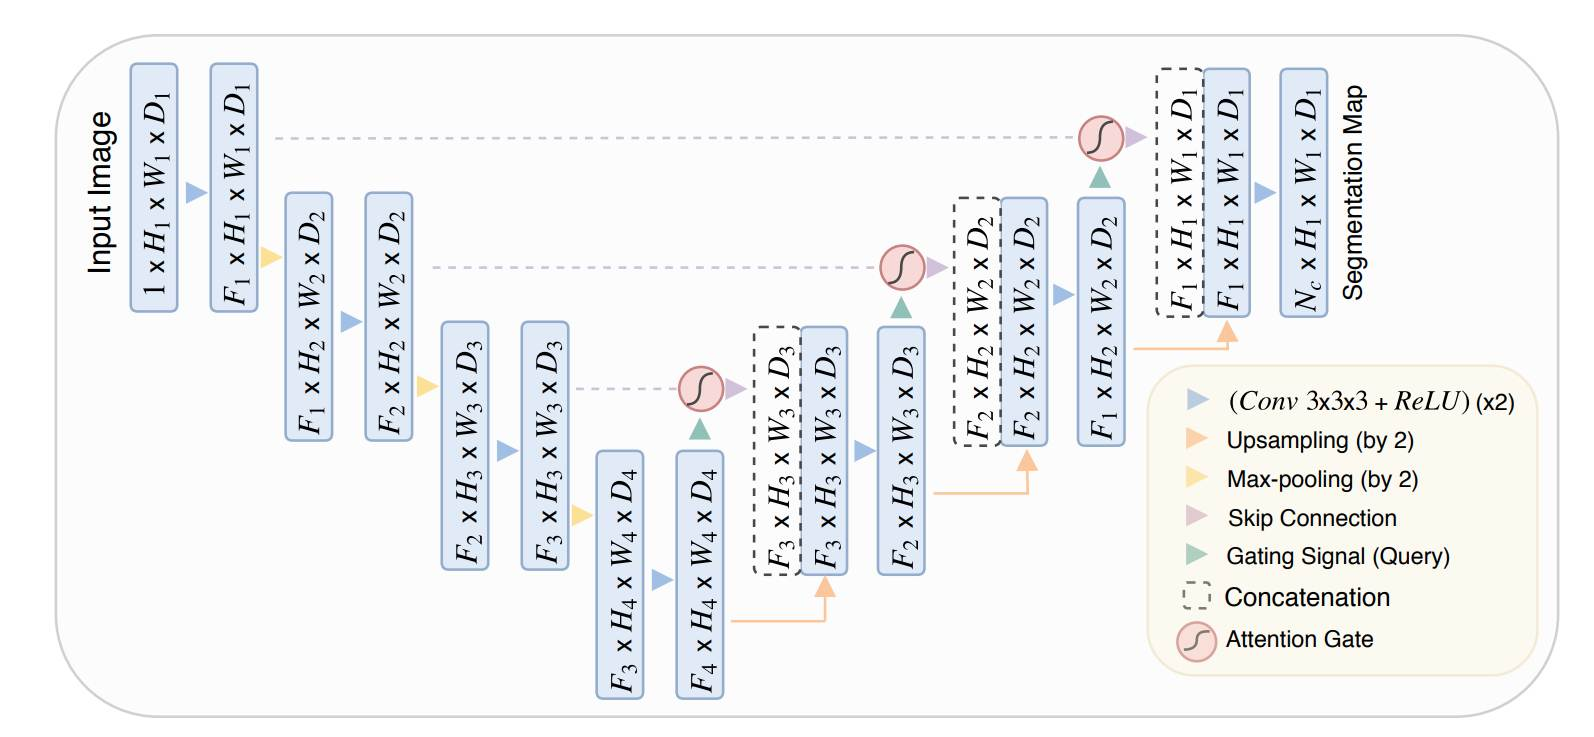

In [ ]:

# # Wrapper function to switch between different loss functions
# loss_functions = ['dice_loss', 'binary_crossentropy', 'wbcdl', 'focal_loss']
# def get_loss_function(loss_name):
#     if loss_name == 'dice_loss':
#         return dice_loss
#     elif loss_name == 'binary_crossentropy':
#         return 'binary_crossentropy'
#     elif loss_name == 'focal_loss':
#         return BinaryFocalLoss(2.0)
#     elif loss_name == 'wbcdl':
#       return weighted_binary_crossentropy
#     else:
#         raise ValueError('Invalid loss function name')


# activations = ['relu', 'lru']
# def get_activation_function(activation):
#   if activation == 'relu':
#     return 'relu'
#   elif activation == 'lru':
#     return LeakyReLU()
#   else:
#     raise ValueError("Invalid activation function name!")

In [ ]:
# ! pip install utils

In [ ]:
# import tensorflow as tf

# from keras import backend as K
# from keras.models import *
# from keras.layers import *
# from keras.optimizers import *
# from keras.losses import *
# from focal_loss import BinaryFocalLoss
# # from utils.utils import f1_m, precision_m, recall_m, dsc

# from sklearn.metrics import *

# K.set_image_data_format('channels_last')  # TF dimension ordering in this code
# kinit = 'glorot_normal'


# def expend_as(tensor, rep,name):
# 	my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
# 	return my_repeat


# def AttnGatingBlock(x, g, inter_shape, activation, name):
#     ''' take g which is the spatially smaller signal, do a conv to get the same
#     number of feature channels as x (bigger spatially)
#     do a conv on x to also get same geature channels (theta_x)
#     then, upsample g to be same size as x
#     add x and g (concat_xg)
#     relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''

#     shape_x = tf.keras.backend.int_shape(x) # 32
#     shape_g = tf.keras.backend.int_shape(g) # 16

#     theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl' + name)(x) # 16
#     shape_theta_x = tf.keras.backend.int_shape(theta_x)

#     phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
#     upsample_g = Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same', name='g_up' + name)(phi_g)

#     concat_xg = add([upsample_g, theta_x])
#     act_xg = Activation(activation)(concat_xg)
#     psi = Conv2D(1, (1, 1), padding='same', name='psi' + name)(act_xg)
#     sigmoid_xg = Activation('sigmoid')(psi)
#     shape_sigmoid = tf.keras.backend.int_shape(sigmoid_xg)

#     upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) # 32

#     # Calculate the output shape for the Lambda layer
#     # The output shape will be (batch_size, height, width, original_channels_of_x)
#     output_shape_for_lambda = (shape_x[0], shape_x[1], shape_x[2], shape_x[3])

#     upsample_psi = Lambda(
#         lambda x_input, repnum: K.repeat_elements(x_input, repnum, axis=3),
#         arguments={'repnum': shape_x[3]},
#         output_shape=output_shape_for_lambda, # Explicitly specify output_shape
#         name='psi_up' + name
#     )(upsample_psi)

#     y = multiply([upsample_psi, x], name='q_attn' + name)
#     result = Conv2D(shape_x[3], (1, 1), padding='same', name='q_attn_conv' + name)(y)
#     result_bn = BatchNormalization(name='q_attn_bn' + name)(result)

#     return result_bn

# def UnetConv2D(input, outdim, is_batchnorm, activation, name):
# 	print(f"DEBUG: UnetConv2D input shape for {name}: {input.shape}") # Add this line
#   x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
# 	if is_batchnorm:
# 		x =BatchNormalization(name=name + '_1_bn')(x)
# 	x = Activation(activation,name=name + '_1_act')(x)

# 	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
# 	if is_batchnorm:
# 		x = BatchNormalization(name=name + '_2_bn')(x)
# 	x = Activation(activation, name=name + '_2_act')(x)
# 	return x


# def UnetGatingSignal(input, is_batchnorm, activation, name):
#     ''' this is simply 1x1 convolution, bn, activation '''
#     # Corrected line: Use tf.keras.backend.int_shape or input.shape
#     shape = tf.keras.backend.int_shape(input) # or shape = input.shape
#     x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same", kernel_initializer=kinit, name=name + '_conv')(input)
#     if is_batchnorm:
#         x = BatchNormalization(name=name + '_bn')(x)
#     x = Activation(activation, name=name + '_act')(x)
#     return x

# K.set_image_data_format('channels_last')  # TF dimension ordering in this code
# kinit = 'glorot_normal'

# def attn_unet(hp, pretrained_weights = None, input_size = (512,512,3)):

#         # some hyperparameters
#         filtersFirstLayer = hp.Choice('firstFilterLayer', [32,64,128])

#         activation_func_name = hp.Choice('activations', activations)
#         activation = get_activation_function(activation_func_name)

#         is_batchnorm = hp.Boolean('is_batchnorm')
#         lr = hp.Float('lr', min_value=0.0001, max_value=0.01, sampling='log')
#         loss_func_name = hp.Choice('loss_func', loss_functions)
#         loss_func = get_loss_function(loss_func_name)

#         inputs = Input(shape=input_size)
#         print(f"DEBUG: Initial model input shape: {inputs.shape}")
#         conv1 = UnetConv2D(inputs, filtersFirstLayer, is_batchnorm=is_batchnorm, activation=activation, name='conv1')
#         pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#         conv2 = UnetConv2D(pool1, filtersFirstLayer, is_batchnorm=is_batchnorm, activation=activation, name='conv2')
#         pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#         conv3 = UnetConv2D(pool2, filtersFirstLayer*2, is_batchnorm=is_batchnorm, activation=activation, name='conv3')
#         #conv3 = Dropout(0.2,name='drop_conv3')(conv3)
#         pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#         conv4 = UnetConv2D(pool3, filtersFirstLayer*2, is_batchnorm=is_batchnorm, activation=activation, name='conv4')
#         #conv4 = Dropout(0.2, name='drop_conv4')(conv4)
#         pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#         center = UnetConv2D(pool4, filtersFirstLayer*4, is_batchnorm=is_batchnorm, activation=activation, name='center')

#         g1 = UnetGatingSignal(center, is_batchnorm=is_batchnorm, activation=activation, name='g1')
#         attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, activation, '_1')
#         up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(center), attn1], name='up1')

#         g2 = UnetGatingSignal(up1, is_batchnorm=is_batchnorm, activation=activation, name='g2')
#         attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, activation, '_2')
#         up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up1), attn2], name='up2')

#         g3 = UnetGatingSignal(up1, is_batchnorm=is_batchnorm, activation=activation, name='g3')
#         attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, activation, '_3')
#         up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up2), attn3], name='up3')

#         up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up3), conv1], name='up4')
#         conv10 = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)

#         model = Model(inputs, conv10)

#         model.compile(optimizer = Adam(learning_rate=lr), loss = loss_func, metrics = ['accuracy', f1_m, precision_m, recall_m, dsc])
#         # model.summary()

#         if(pretrained_weights):
#             model.load_weights(pretrained_weights)

#         return model

In [ ]:
!pip install focal-loss

import tensorflow as tf
import cv2
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from focal_loss import BinaryFocalLoss

def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true) # Using backend flatten
    y_pred_f = tf.keras.backend.flatten(y_pred) # Using backend flatten
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def weighted_binary_crossentropy(y_true, y_pred, weight_zero=0.5, weight_one=0.5):
    bce = keras.losses.binary_crossentropy(y_true, y_pred)
    weights = y_true * weight_one + (1. - y_true) * weight_zero
    weighted_bce = tf.reduce_mean(bce * weights) # Corrected: K.mean to tf.reduce_mean
    return weighted_bce

def get_activation_function(name):
    if name == 'relu':
        return 'relu'
    elif name == 'lru':
        return tf.keras.layers.LeakyReLU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

def get_loss_function(name):
    if name == 'dice_loss':
        return dice_loss
    elif name == 'binary_crossentropy':
        return 'binary_crossentropy'
    elif name == 'wbcdl':
        return weighted_binary_crossentropy
    elif name == 'focal_loss':
        return BinaryFocalLoss()
    else:
        raise ValueError(f"Unknown loss function: {name}")

activations = ['relu', 'lru']
loss_functions = ['dice_loss', 'binary_crossentropy', 'wbcdl', 'focal_loss']

K.set_image_data_format('channels_last')
kinit = 'glorot_normal'

# The expend_as function is not used in attn_unet, so it's kept as is for completeness.
def expend_as(tensor, rep,name):
  my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep},  name='psi_up'+name)(tensor)
  return my_repeat


def AttnGatingBlock(x, g, inter_shape, activation, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''

    shape_x = tf.keras.backend.int_shape(x)
    shape_g = tf.keras.backend.int_shape(g)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl' + name)(x)
    shape_theta_x = tf.keras.backend.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same', name='g_up' + name)(phi_g)

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation(activation)(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi' + name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = tf.keras.backend.int_shape(sigmoid_xg)

    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    # Corrected: Wrap tf.tile in a Lambda layer
    channel_multiplier = shape_x[3]
    upsample_psi = Lambda(
        lambda t: tf.tile(t, [1, 1, 1, channel_multiplier]),
        output_shape=(shape_x[1], shape_x[2], shape_x[3]),  # Explicitly specify output_shape
        name='psi_up_tile' + name
    )(upsample_psi)

    y = multiply([upsample_psi, x], name='q_attn' + name)
    result = Conv2D(shape_x[3], (1, 1), padding='same', name='q_attn_conv' + name)(y)
    result_bn = BatchNormalization(name='q_attn_bn' + name)(result)

    return result_bn

def UnetConv2D(input, outdim, is_batchnorm, activation, name):
  x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
  if is_batchnorm:
    x =BatchNormalization(name=name + '_1_bn')(x)
  x = Activation(activation,name=name + '_1_act')(x)

  x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
  if is_batchnorm:
    x = BatchNormalization(name=name + '_2_bn')(x)
  x = Activation(activation, name=name + '_2_act')(x)
  return x


def UnetGatingSignal(input, is_batchnorm, activation, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = tf.keras.backend.int_shape(input)
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same", kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation(activation, name=name + '_act')(x)
    return x


def attn_unet(hp, pretrained_weights = None, input_size = (512,512,3)):
        K.set_image_data_format('channels_last')

        filtersFirstLayer = hp.Choice('firstFilterLayer', [32,64,128])
        activation_func_name = hp.Choice('activations', activations)
        activation = get_activation_function(activation_func_name)
        is_batchnorm = hp.Boolean('is_batchnorm')
        lr = hp.Float('lr', min_value=0.0001, max_value=0.01, sampling='log')
        loss_func_name = hp.Choice('loss_func', loss_functions)
        loss_func = get_loss_function(loss_func_name)

        inputs = Input(shape=input_size)
        conv1 = UnetConv2D(inputs, filtersFirstLayer, is_batchnorm=is_batchnorm, activation=activation, name='conv1')
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = UnetConv2D(pool1, filtersFirstLayer, is_batchnorm=is_batchnorm, activation=activation, name='conv2')
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = UnetConv2D(pool2, filtersFirstLayer*2, is_batchnorm=is_batchnorm, activation=activation, name='conv3')
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = UnetConv2D(pool3, filtersFirstLayer*2, is_batchnorm=is_batchnorm, activation=activation, name='conv4')
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

        center = UnetConv2D(pool4, filtersFirstLayer*4, is_batchnorm=is_batchnorm, activation=activation, name='center')

        g1 = UnetGatingSignal(center, is_batchnorm=is_batchnorm, activation=activation, name='g1')
        attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, activation, '_1')
        up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(center), attn1], name='up1')

        g2 = UnetGatingSignal(up1, is_batchnorm=is_batchnorm, activation=activation, name='g2')
        attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, activation, '_2')
        up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up1), attn2], name='up2')

        g3 = UnetGatingSignal(up1, is_batchnorm=is_batchnorm, activation=activation, name='g3')
        attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, activation, '_3')
        up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up2), attn3], name='up3')

        up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation=activation, kernel_initializer=kinit)(up3), conv1], name='up4')
        conv10 = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)

        model = Model(inputs, conv10)

        # Note: Corrected learning_rate argument name for Adam optimizer
        model.compile(optimizer = Adam(learning_rate=lr), loss = loss_func, metrics = ['accuracy', f1_m, precision_m, recall_m, dsc])

        if(pretrained_weights):
            model.load_weights(pretrained_weights)

        return model

In [ ]:
import keras_tuner
model = attn_unet(keras_tuner.HyperParameters())

In [ ]:
# Initialize the tuner (e.g., RandomSearch)
tuner = keras_tuner.RandomSearch(
    attn_unet,
    objective=keras_tuner.Objective("val_f1_m", direction="max"),      # Define the metric to optimize
    max_trials=3,             # Number of hyperparameter combinations to try
    directory='/content/flood/kt',      # Directory to save the results
    project_name='flood_tuner' # Name for the project
)

In [ ]:

# Define training data and start the search
tuner.search(train_dataset, epochs=3, validation_data=test_dataset)

Trial 3 Complete [00h 00m 01s]

Best val_f1_m So Far: 0.6572266221046448
Total elapsed time: 01h 10m 09s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
firstFilterLayer (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
activations (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'lru'], 'ordered': False}
is_batchnorm (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
loss_func (Choice)
{'default': 'dice_loss', 'conditions': [], 'values': ['dice_loss', 'binary_crossentropy', 'wbcdl', 'focal_loss'], 'ordered': False}


In [ ]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 146 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1 (Conv2D)    │ (None, 512, 512,  │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1_act         │ (None, 512, 512,  │          0 │ conv1_1[0][0]     │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2 (Conv2D)    │ (None, 512, 512,  │    147,584 │ conv1_1_act[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2_act         │ (None, 512, 512,  │          0 │ conv1_2[0][0]     │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv1_2_act[0][0] │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1 (Conv2D)    │ (None, 256, 256,  │    147,584 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1_act         │ (None, 256, 256,  │          0 │ conv2_1[0][0]     │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2 (Conv2D)    │ (None, 256, 256,  │    147,584 │ conv2_1_act[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2_act         │ (None, 256, 256,  │          0 │ conv2_2[0][0]     │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2_2_act[0][0] │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_1 (Conv2D)    │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_1_act         │ (None, 128, 128,  │          0 │ conv3_1[0][0]     │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_2 (Conv2D)    │ (None, 128, 128,  │    590,080 │ conv3_1_act[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_2_act         │ (None, 128, 128,  │          0 │ conv3_2[0][0]     │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv3_2_act[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4_1 (Conv2D)    │ (None, 64, 64,    │    590,080 │ max_pooling2d_2[

 Total params: 13,482,628 (51.43 MB)

 Trainable params: 13,481,348 (51.43 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
tuner.results_summary()

Results summary
Results in /content/flood/kt/flood_tuner
Showing 10 best trials
Objective(name="val_f1_m", direction="max")

Trial 2 summary
Hyperparameters:
firstFilterLayer: 128
activations: relu
is_batchnorm: False
lr: 0.00330588674286921
loss_func: binary_crossentropy
Score: 0.7196947336196899

Trial 1 summary
Hyperparameters:
firstFilterLayer: 32
activations: lru
is_batchnorm: False
lr: 0.0049406530672152634
loss_func: binary_crossentropy
Score: 0.6627876162528992

Trial 0 summary
Hyperparameters:
firstFilterLayer: 32
activations: lru
is_batchnorm: True
lr: 0.004155575622558665
loss_func: focal_loss
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_a

## Training model

In [ ]:
# callback functions
checkpointer = tf.keras.callbacks.ModelCheckpoint(f"/content/flood/flood_best.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=5, verbose=1, mode='max')

callbacks = [
    earlyStopping,
    checkpointer
    ]

# model training
history = model.fit(train_dataset,epochs=2,
                    verbose = 1,
                    # validation_split=0.15,
                    validation_data=test_dataset,
                    callbacks=callbacks)

# save the model weights at the end of the training process
model.save(f"/content/flood/flood_best.h5")

Epoch 1/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.7715 - dsc: 0.6448 - f1_m: 0.7363 - loss: 0.3552 - precision_m: 0.6546 - recall_m: 0.8550
Epoch 1: val_f1_m improved from -inf to 0.64413, saving model to /content/flood/flood_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7723 - dsc: 0.6456 - f1_m: 0.7370 - loss: 0.3544 - precision_m: 0.6556 - recall_m: 0.8551 - val_accuracy: 0.5909 - val_dsc: 0.5627 - val_f1_m: 0.6441 - val_loss: 0.4416 - val_precision_m: 0.4834 - val_recall_m: 0.9798
Epoch 2/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.8448 - dsc: 0.7532 - f1_m: 0.8001 - loss: 0.2468 - precision_m: 0.7670 - recall_m: 0.8409
Epoch 2: val_f1_m improved from 0.64413 to 0.65943, saving model to /content/flood/flood_best.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8444 - dsc: 0.7530 - f1_m: 0.7995 - loss: 0.2470 - precision_m: 0.7663 - recall_m: 0.8404 - val_accuracy: 0.6660 - val_dsc: 0.6023 - val_f1_m: 0.6594 - val_loss: 0.3885 - val_precision_m: 0.5045 - val_recall_m: 0.9669


## Model performance

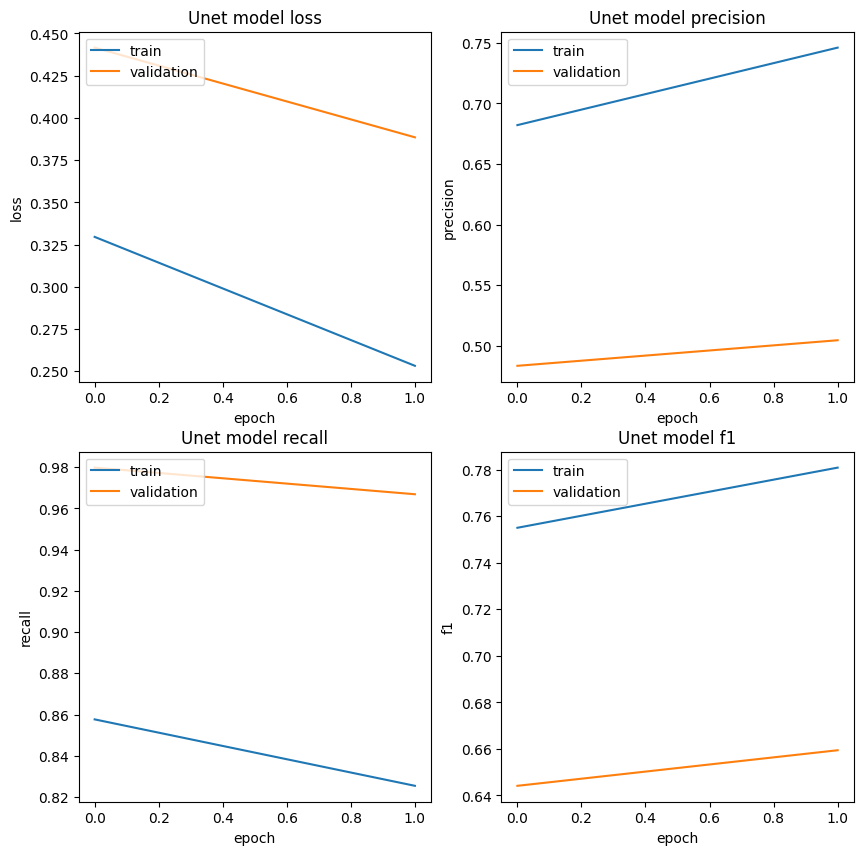

In [ ]:
fig,((ax11, ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(10,10))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

## Load best model

In [ ]:
# from keras.models import load_model

# # # Define the custom loss function before loading the model
# custom_objects = {"f1_m": f1_m, 'precision_m': precision_m, 'recall_m': recall_m, 'dsc': dsc, }

# model = load_model('/content/flood/flood_best.h5', custom_objects=custom_objects)

# # pred

In [ ]:
def AttnGatingBlock(x, g, inter_shape, activation, name):
    shape_x = tf.keras.backend.int_shape(x)
    shape_g = tf.keras.backend.int_shape(g)

    # 1x1 convolution for input feature map x
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl' + name)(x)
    shape_theta_x = tf.keras.backend.int_shape(theta_x)

    # 1x1 convolution for gating signal g
    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)

    # Upsample gating signal to match theta_x
    upsample_g = Conv2DTranspose(
        inter_shape,
        (3, 3),
        strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
        padding='same',
        name='g_up' + name
    )(phi_g)

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation(activation)(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same', name='psi' + name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = tf.keras.backend.int_shape(sigmoid_xg)

    # Upsample psi to match x
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    channel_multiplier = shape_x[3]

    # Define output shape function
    def tile_output_shape(input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], input_shape[3] * channel_multiplier)

    # Fix Lambda layer with output_shape
    upsample_psi = Lambda(
        lambda t: tf.tile(t, [1, 1, 1, channel_multiplier]),
        output_shape=tile_output_shape,
        name='psi_up_tile' + name
    )(upsample_psi)

    y = multiply([upsample_psi, x], name='q_attn' + name)
    result = Conv2D(shape_x[3], (1, 1), padding='same', name='q_attn_conv' + name)(y)
    result_bn = BatchNormalization(name='q_attn_bn' + name)(result)

    return result_bn


In [ ]:
# accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
loss, accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
print(loss, accuracy, f1_score, precision, recall, dsc)


0.37412071228027344 0.666520357131958 0.6799613833427429 0.526585042476654 0.9683719873428345 0.6161239743232727


## Prediction on custom images

In [ ]:
import glob
imgs = glob.glob('/content/flood/*.jpg')

img_test = np.zeros((3, 512, 512, 3))
for index, i in enumerate(imgs):
  img = cv2.imread(i)
  img = cv2.resize(img, (512, 512))
  img = img / 255.0
  # print(img.shape)
  # img_test[index] = img


In [ ]:
pred = model.predict(img_test)
pred = np.where(pred > 0.5, 1, 0)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(3, 512, 512, 1)

In [ ]:
# fig,(axes)= plt.subplots(3, 2, figsize=(12,12))

# for i in range(3):
#     # Load and display the original image
#     axes[i, 0].imshow(img_test[i])
#     axes[i, 0].set_title(f'Image {i+1}')
#     axes[i, 0].axis('off')

#     # Load and display the corresponding prediction
#     axes[i, 1].imshow(pred[i])
#     axes[i, 1].set_title(f'Prediction {i+1}')
#     axes[i, 1].axis('off')

# plt.tight_layout()


Image 1 shape: (512, 512, 3), min: 0.0, max: 0.0
Prediction 1 shape: (512, 512, 1), min: 0, max: 0


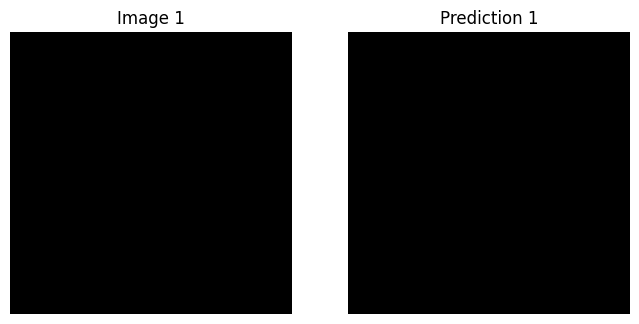


Image 2 shape: (512, 512, 3), min: 0.0, max: 0.0
Prediction 2 shape: (512, 512, 1), min: 0, max: 0


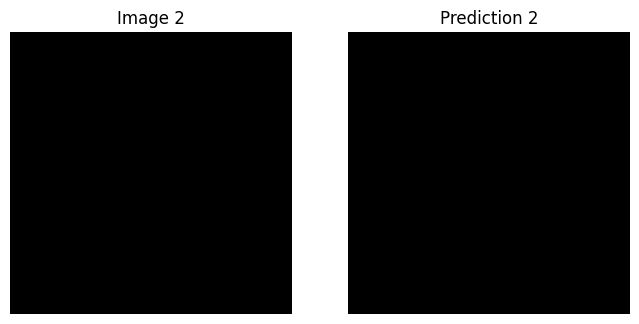


Image 3 shape: (512, 512, 3), min: 0.0, max: 0.0
Prediction 3 shape: (512, 512, 1), min: 0, max: 0


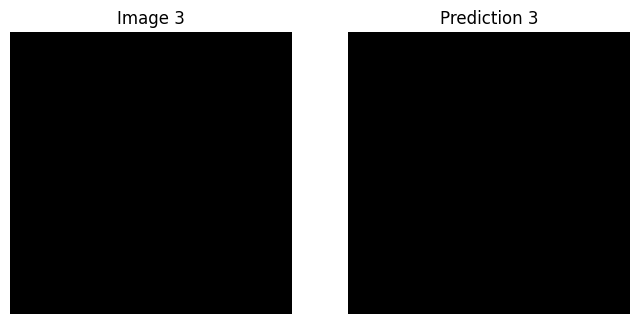

In [ ]:
for i in range(3):
    img = img_test[i]
    pred_img = pred[i]

    print(f"\nImage {i+1} shape: {img.shape}, min: {img.min()}, max: {img.max()}")
    print(f"Prediction {i+1} shape: {pred_img.shape}, min: {pred_img.min()}, max: {pred_img.max()}")

    plt.figure(figsize=(8, 4))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.title(f'Image {i+1}')
    if img.shape[-1] == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img if img.max() <= 1 else img / 255.0)
    plt.axis('off')

    # Show prediction
    plt.subplot(1, 2, 2)
    plt.title(f'Prediction {i+1}')
    plt.imshow(pred_img.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

Image 1 min/max: 0.0235294122248888/1.0
Prediction 1 min/max: 0.022255349904298782/0.9998370409011841


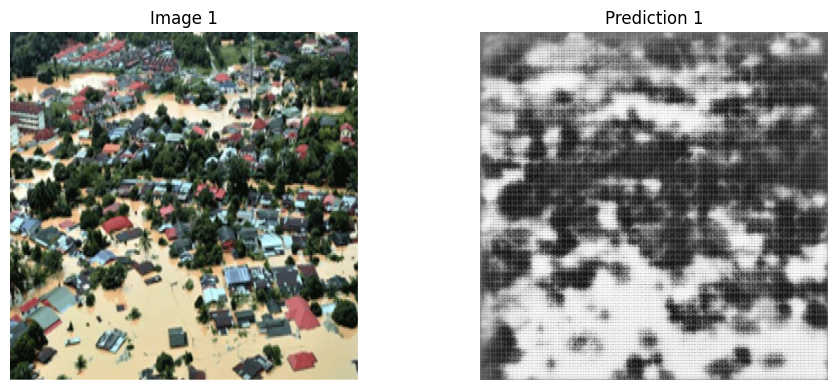


Image 2 min/max: 0.0/1.0
Prediction 2 min/max: 0.03676080331206322/0.9996780157089233


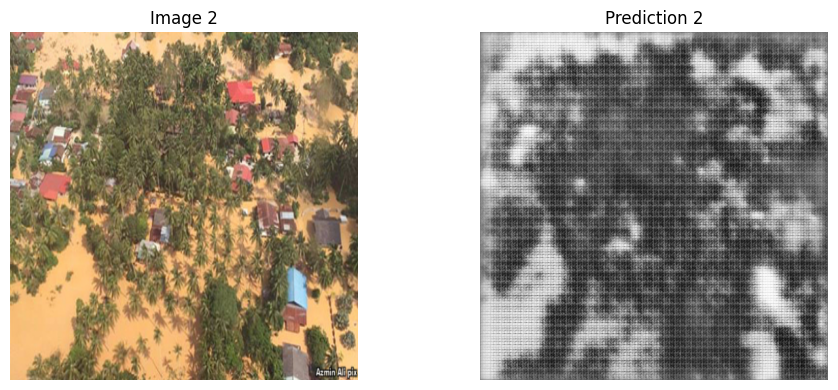


Image 3 min/max: 0.0/1.0
Prediction 3 min/max: 0.03525703027844429/0.9999632835388184


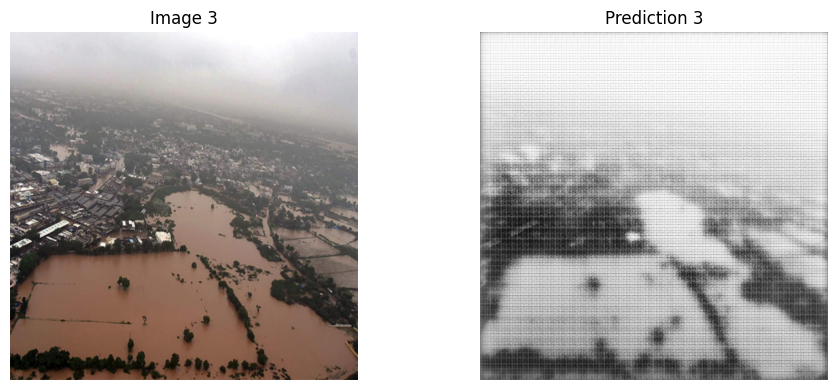

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Step 1: Load test images properly
image_paths = sorted(glob('/content/drive/MyDrive/archive/Image/*.jpg'))

img_test = []
for path in image_paths[:3]:  # Load only 3 for example
    img = cv2.imread(path)               # BGR format
    if img is None:
        print(f"Failed to load {path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (512, 512))           # Resize if needed
    img = img.astype('float32') / 255.0         # Normalize to [0, 1]
    img_test.append(img)

img_test = np.array(img_test)

# Optional: Expand dims if model expects batch of (512, 512, 3)
# img_test.shape -> (3, 512, 512, 3)

# Step 2: Predict using model
pred = model.predict(img_test)

# Step 3: Display results
for i in range(len(img_test)):
    img = img_test[i]
    pred_img = pred[i]

    print(f"\nImage {i+1} min/max: {img.min()}/{img.max()}")
    print(f"Prediction {i+1} min/max: {pred_img.min()}/{pred_img.max()}")

    plt.figure(figsize=(10, 4))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')

    # Display prediction (grayscale)
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(pred_img), cmap='gray')
    plt.title(f"Prediction {i+1}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
